# ML Classifiers

**Goal:** Given a sentence as input, classify it as either a prediction or non-prediction.

In [1]:
import os
import sys
import warnings

import pandas as pd

from tqdm import tqdm

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../'))

# import log_files
from data_processing import DataProcessing
from feature_extraction import SpacyFeatureExtraction
# from classification_models import SkLearnPerceptronModel, SkLearnSGDClassifier, EvaluationMetric
from classification_models import SkLearnModelFactory
from metrics import EvaluationMetric

In [2]:
pd.set_option('max_colwidth', 800)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

## Load Data

In [3]:
print("======= LOAD DATA =======")

======= LOAD DATA =======


In [4]:
base_data_path = os.path.join(notebook_dir, '../data')
combine_data_path = os.path.join(base_data_path, 'financial_phrase_bank/combined_generated_fin_phrase_bank')
data_path = os.path.join(combine_data_path, 'combined_generated_fin_phrase_bank-v3.csv')

In [5]:
df = DataProcessing.load_from_file(data_path, 'csv', sep=',')
df

Base Sentence  \
0                                                                                                                                                                                                                               JPMorgan Chase forecasts that the net profit at Amazon potentially decrease in Q3 of 2027.   
1                                                                                                                                                                                                                            On August 21, 2024, Bank of America speculates the revenue at Microsoft will likely increase.   
2                                                                                                                                                                                                                                             Citigroup predicts on 2024-08-21, the operating income at Alphabet may rise.   
3                                                                                                                                                                                                                        According to Goldman Sachs, the research and development expenses at Facebook would fall in 2025.   
4                                                                                                                                                                                            In 21 August 2024, Morgan Stanley envisions that the gross profit at Johnson & Johnson has some probability to remain stable.   
5                                                                                                                                                                                                                                        The stock price at Visa should stay same in Q2 of 2026, according to Wells Fargo.   
6                                                                                                                                                                                                                                     JPMorgan forecasts that the revenue at Microsoft potentially decrease in Q3 of 2027.   
7                                                                                                                                                                                                On August 25, 2024, to September 25, 2025, Citigroup speculates the net profit at Johnson & Johnson will likely increase.   
8                                                                                                                                                                                                                                           Bank of America predicts on 2024-08-21, the operating income at Visa may rise.   
9                                                                                                                                                                                                                     According to Goldman Sachs, the research and development expenses at Alphabet would fall in 2029 Q2.   
10                                                                                                                                                                                               In 21 August 2024, Wells Fargo envisions that the gross profit at Procter & Gamble has some probability to remain stable.   
11                                                                                                                                                                                                                                  The stock price of Amazon should stay same in 2025-03-15, according to Morgan Stanley.   
12                                                                                                                                                                The W

In [6]:
print(len(df))
# df.drop(columns=['Unnamed: 0'], inplace=True)
print(f"\tShape: {df.shape}, \nSubset of Data:{df.head(7)}")
df.shape, df.tail(3)

2825
	Shape: (2825, 3), 
Subset of Data:                                                                                                                   Base Sentence  \
0                                     JPMorgan Chase forecasts that the net profit at Amazon potentially decrease in Q3 of 2027.   
1                                  On August 21, 2024, Bank of America speculates the revenue at Microsoft will likely increase.   
2                                                   Citigroup predicts on 2024-08-21, the operating income at Alphabet may rise.   
3                              According to Goldman Sachs, the research and development expenses at Facebook would fall in 2025.   
4  In 21 August 2024, Morgan Stanley envisions that the gross profit at Johnson & Johnson has some probability to remain stable.   
5                                              The stock price at Visa should stay same in Q2 of 2026, according to Wells Fargo.   
6                                   

((2825, 3),
                                                                                                        Base Sentence  \
 2822  These moderate but significant changes resulted in a significant 24-32 % reduction in the estimated CVD risk .   
 2823                Uponor improved its performance in spite of the decrease in residential construction in the US .   
 2824                                                                       The inventor was issued U.S. Patent No. .   
 
       Sentence Label  Author Type  
 2822               0            1  
 2823               0            1  
 2824               0            1  )

## Shuffle Data

In [7]:
df.head(3)

Base Sentence  \
0     JPMorgan Chase forecasts that the net profit at Amazon potentially decrease in Q3 of 2027.   
1  On August 21, 2024, Bank of America speculates the revenue at Microsoft will likely increase.   
2                   Citigroup predicts on 2024-08-21, the operating income at Alphabet may rise.   

   Sentence Label  Author Type  
0               1            0  
1               1            0  
2               1            0

In [8]:
print("======= SHUFFLE DATA =======")

======= SHUFFLE DATA =======


In [9]:
shuffled_df = DataProcessing.shuffle_df(df)
print(f"\tShape: {shuffled_df.shape}, \nSubset of Data:{shuffled_df.head(7)}")

	Shape: (2825, 3), 
Subset of Data:                                                                                                                                            Base Sentence  \
0  Net income from life insurance rose to EUR 16.5 mn from EUR 14.0 mn , and net income from non-life insurance to EUR 22.6 mn from EUR 15.2 mn in 2009 .   
1                                      According to the financial senior level person at JPMorgan Chase, the revenue at Alphabet had risen in Q1 of 2029.   
2                                       On 11th of October 2025, the World Health Organization monitored the obesity rates at rural high schools changed.   
3                                                                      To be number one means creating added value for stakeholders in everything we do .   
4                                                                                    Dr. Smith noted on 09/15/2024, the prevalence of heart disease fell.   
5                      

## Extract Sentence Embeddings

In [10]:
print("======= EMBED SENTENCES: Spacy =======")

======= EMBED SENTENCES: Spacy =======


In [11]:
spacy_fe = SpacyFeatureExtraction(shuffled_df, 'Base Sentence')
spacy_fe

In [12]:
spacy_sentence_embeddings_df = spacy_fe.sentence_feature_extraction(attach_to_df=True)
# print(f"{spacy_sentence_embeddings_df.head(3)}")

100%|██████████| 2825/2825 [00:09<00:00, 293.51it/s]


## Normalize Embeddings

- Why: Getting the below warnings
    1. sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul ret = a @ b
    2. sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul ret = a @ b
    3. sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul ret = a @ b

- Normalize will place data within "boundaries" to be all on one scale

In [13]:
print("======= NORMALIZE EMBEDDINGS =======")

======= NORMALIZE EMBEDDINGS =======


In [14]:
from sklearn.preprocessing import StandardScaler

# Convert embeddings to matrix if not already
embeddings_matrix = pd.DataFrame(spacy_sentence_embeddings_df["Embedding"].tolist())

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings_matrix)

spacy_sentence_embeddings_df['Normalized Embeddings'] = list(scaled_embeddings)

In [15]:
# print(f"{spacy_sentence_embeddings_df.head(3)}")
# spacy_sentence_embeddings_df
# print(f"{spacy_sentence_embeddings_df.to_dict()}")

for idx, row in spacy_sentence_embeddings_df.iterrows():
    text = row['Base Sentence']
    label = row['Sentence Label']
    embedding = row['Embedding']
    norm_embedding = row['Normalized Embeddings']
    if idx < 7:
        print(f"{idx}\n Sentence: {text}\n Label: {label}\n Embeddings Shape: {embedding.shape}\n\t Embeddings Subset [:6]: {embedding[:6]} \n Norm Embeddings: {norm_embedding.shape}, \n\tNorm Embeddings Subset [:6]: {norm_embedding[:6]}")

0
 Sentence: Net income from life insurance rose to EUR 16.5 mn from EUR 14.0 mn , and net income from non-life insurance to EUR 22.6 mn from EUR 15.2 mn in 2009 .
 Label: 0
 Embeddings Shape: (300,)
	 Embeddings Subset [:6]: [-0.22492191  0.33076787  0.00159167  0.02455215  0.24869722 -0.12270349] 
 Norm Embeddings: (300,), 
	Norm Embeddings Subset [:6]: [-1.6847831   1.3524358  -0.06767292  0.96886927  2.4268584  -1.2660933 ]
1
 Sentence: According to the financial senior level person at JPMorgan Chase, the revenue at Alphabet had risen in Q1 of 2029.
 Label: 0
 Embeddings Shape: (300,)
	 Embeddings Subset [:6]: [-0.14797592  0.18903823  0.02756777  0.00196567  0.06092546  0.05799879] 
 Norm Embeddings: (300,), 
	Norm Embeddings Subset [:6]: [-0.753743   -0.5607003   0.32978797  0.60701054  0.11148097  1.2488207 ]
2
 Sentence: On 11th of October 2025, the World Health Organization monitored the obesity rates at rural high schools changed.
 Label: 0
 Embeddings Shape: (300,)
	 Embeddi

In [16]:
embeddings_col_name = 'Normalized Embeddings'

## Split Data


> **Stratification preserves the original dataset ratio when splitting into train-test splits.**  
> **Example**: If we have 1,000 samples: 920 non-predictions, 80 predictions  
> - **Train size = 0.8 → 800 samples in train**  
>     - **With stratify**: train ≈ 736 non-predictions, 64 predictions  
>     - **Without stratify**: train could randomly have 797 non-predictions and 3 predictions (or worse)  
>     - **Without stratify**: train could randomly have 100 non-predictions and 700 predictions (or worse)  
> - **Test size = 0.2 → 200 samples in test**  
>     - **With stratify**: test ≈ 184 non-predictions, 16 predictions  
>     - **Without stratify**: test could randomly have 198 non-predictions and 2 predictions (or worse)  


In [17]:
print("======= SPLIT DATA =======")

======= SPLIT DATA =======


In [18]:
spacy_sentence_embeddings_df.head(3)

Base Sentence  \
0  Net income from life insurance rose to EUR 16.5 mn from EUR 14.0 mn , and net income from non-life insurance to EUR 22.6 mn from EUR 15.2 mn in 2009 .   
1                                      According to the financial senior level person at JPMorgan Chase, the revenue at Alphabet had risen in Q1 of 2029.   
2                                       On 11th of October 2025, the World Health Organization monitored the obesity rates at rural high schools changed.   

   Sentence Label  Author Type  \
0               0            1   
1               0            0   
2               0            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Embedding  \
0  [-0.22492191, 0.33076787, 0.0015916728, 0.024552153, 0.24869722, -0.12270349, 0.077695, 0.036100093, 0.17108163, 1.3147347, -0.44673762, 0.13499488, -0.09395125, 0.022185089, 0.10875409, 0.061217517, 0.03683422, 1.1383543, -0.05511938, 0.033903327, 0.035543617, -0.053965002, -0.092551306, -0.051658418, 0.11317858, 0.07838255, -0.10281078, -0.0828436, -0.08695139, 0.16029881, 0.03223964, -0.046120018, -0.12969352, 0.04341615, 0.021033173, -0.009246599, -0.16340375, -0.09167824, -0.018575398, 0.13226306, 0.017988915, 0.051376373, 0.15791693, -0.10549688, -0.07, 0.111039765, 0.15711744, 0.0023394853, 0.12900947, 0.01061755, -0.12041667, -0.042009674, -0.09062783, -0.08716391, 0.14827925, -0.10065144, -0.048354708, 0.044614907, -0.06126854, -0.093334354, -0.11243491, -0.107763015, -0.26356...   
1  [-0.14797592, 0.18903823, 0.027567772, 0.0019656746, 0.060925458, 0.05799879, -0.024907697, 0.13308369, 0.11494873, 2.010199, -0.25961187, 0.0109938225, 0.1105645, 0.07865309, -0.029267984, -0.02273451, -0.024475409, 0.9206356, -0.111091964, 0.0010093455, 0.04381073, 0.10480573, -0.018486956, -0.061253823, 0.07465677, 0.12606715, -0.060426887, 0.029329566, -0.025426142, 0.06758911, 0.057725355, 0.08223564, 0.025920369, 0.18043904, 0.06054687, -0.044482682, -0.026366549, 0.08514258, 0.044186402, 0.010201949, 0.070893876, -0.0047824113, -0.0060838233, -0.093484946, 0.10798281, 0.02062661, -0.0039412733, -0.035238508, -0.013841703, 0.023276232, -0.04481264, -0.020503543, -0.043965098, 0.080525406, -0.011630089, -0.025144821, 0.035508182, -0.07530105, -0.046570312, -0.12124377, 0.03996019,...   
2  [-0.076041564, 0.3122237, 0.026510298, -0.0717942, -0.086790755, -0.010789577, -0.020441111, 0.030986553, 0.026818525, 2.277497, -0.40642172, -0.021653151, 0.09790225, 0.04019418, -0.040514797, -0.040429495, 0.0054392503, 1.2545536, -0.13120344, -0.09417785, -0.0004992186, -0.010959702, 0.094102845, -0.064638995, 0.043657802, -0.00772529, -0.1283721, -0.024550527, -0.054511957, 0.15769775, 0.03518964, 0.011812801, 0.0805304, -0.041667435, 0.051297754, -0.048048753, -0.076382495, 0.114326835, -0.03039441, 0.19640622, -0.010173494, 0.088735, -0.0689217, -0.015006678, 0.11604055, -0.023721, -0.108259395, 0.0055881417, 0.024729151, -0.030221347, -0.08574061, 0.06973127, -0.050878346, -0.078708425, 0.035788704, -0.048028205, 0.15204714, 0.0071707987, 0.12800325, -0.1753889, -0.05890914, -0....   

                                                                                                                                                     

In [19]:
# spacy_embeds = spacy_sentence_embeddings_df['Embedding'].to_list()
cols_with_labels = spacy_sentence_embeddings_df.loc[:, ['Sentence Label', 'Author Type']]
cols_with_labels.head(3)

Sentence Label  Author Type
0               0            1
1               0            0
2               0            0

In [21]:
splits = DataProcessing.split_data(spacy_sentence_embeddings_df, cols_with_labels, stratify=True, stratify_by='Sentence Label')
splits
# print(f"{X_train_df.head(3)}")

[                                                                                                                                                                                                                                                                                                             Base Sentence  \
 54                                                                                                                                                                              According to Atria 's President and CEO Matti Tikkakoski , the company 's Swedish operations significantly improved in the first quarter .   
 2090                                                                                                            The tower it chose to add , due to go into operation in the summer , will increase total capacity to 80 broadsheet or 160 tabloid pages , with the ability to run 32 - and 48-page products side by side .   
 1677                                      

In [23]:
X_train_df, X_test_df, y_train_sentence_df, y_test_sentence_df, y_train_author_df, y_test_author_df = splits
X_train_df.head(3)

Base Sentence  \
54                                                                    According to Atria 's President and CEO Matti Tikkakoski , the company 's Swedish operations significantly improved in the first quarter .   
2090  The tower it chose to add , due to go into operation in the summer , will increase total capacity to 80 broadsheet or 160 tabloid pages , with the ability to run 32 - and 48-page products side by side .   
1677                                                                                                     In Q3 2028, Professor Chen envisioned that her patients' body mass index at the local clinic decreased.   

      Sentence Label  Author Type  \
54                 0            1   
2090               0            1   
1677               0            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Embedding  \
54    [0.041027006, 0.1820981, -0.020990776, -0.017873267, 0.02760573, -0.05120162, 0.037013326, -0.092839114, -0.009454541, 1.8566082, -0.21250282, -0.073992275, 0.13637276, -0.026959503, 0.0036987744, -0.12699701, 0.054408632, 0.86367, -0.11449091, -0.087293826, 0.051253065, 0.060785774, 0.0076474054, -0.2108174, 0.016746499, 0.09260433, -0.15951684, 0.030492347, -0.013935759, -0.07429332, 0.0011344169, -0.001241451, -0.010624001, 0.1094713, 0.0713425, 0.037630994, 0.025294207, -0.009313684, -0.021804791, -0.123197086, 0.0461751, 0.06474435, 0.01552536, -0.073185295, -0.015361861, -0.10975688, 0.039395545, 0.003920167, 0.109445505, 0.115822986, 0.11245847, -0.008725389, -0.047884904, 0.032616522, 0.0598614, -0.0945988, 0.013164907, 0.022863908, -0.015512865, -0.15775046, -0.017384807, 0.01...   
2090  [0.022676554, 0.27905893, -0.005440206, 0.04101572, 0.028533207, -0.022087641, -0.10377527, 0.017977975, -0.037837636, 1.8846042, -0.15306629, 0.07733075, 0.11042544, 0.0016491526, -0.12795655, -0.022667203, -0.06467701, 1.4026767, -0.13643815, -0.061641958, -0.047967315, 0.048904773, -0.040466562, -0.009019414, 0.086929806, 0.008409476, -0.054103896, -0.03744836, -0.026812427, -0.009389524, -0.04112014, 0.1139884, -0.11598987, -0.0002831363, 0.07660422, -0.1346757, -0.09740868, 0.0975301, 0.061730504, -0.041590095, -0.070093796, 0.08762044, 0.018985458, -0.14367935, -0.062360097, 0.041349366, -0.07251717, 0.036065783, -0.019729113, 0.016377065, -0.01018686, 0.038048115, 0.089512795, -0.009121782, 0.019252788, 0.009468689, 0.045341544, -0.07612066, -0.029661197, -0.036368743, 0.0429762...   
1677  [-0.061861046, 0.23680219, -0.0379443, 0.058220647, 0.078254, -0.025313035, 0.031442486, -0.0184335, 0.03042985, 1.8410904, -0.20648515, 0.08007239, 0.18419315, -0.11648165, -0.033785056, 0.017133156, 0.029407453, 1.1232946, -0.17044091, -0.11203464, 0.003896701, 0.088495836, -0.12435456, -0.123019256, 0.08988704, 0.08324601, -0.004029304, 0.051926084, 0.09357063, 0.012874378, -0.036120635, 0.010841602, -0.001974003, 0.04227495, 0.1447469, -0.061285317, 0.041888863, 0.09170372, -0.042803027, -0.018771304, 0.03643465, 0.079883896, 0.0161318, -0.08886372, 0.009178597, 0.05170872, -0.023176154, -0.039468963, 0.09726059, -0.10507055, -0.08307594, 0.016027248, -0.033854246, -0.10610999, 0.050839346, -0.014455145, 0.0532704, -0.12634611, -0.07461981, -0.163592

In [ ]:
sentence_labels_col

In [ ]:
save_df = True

if save_df == True:
    print("Save test set so we can pass these into LLMs")
    # save_path = os.path.join(base_data_path, 'combined_generated_fin_phrase_bank')
    DataProcessing.save_to_file(X_test_df, combine_data_path, 'x_test_set', 'csv')
    DataProcessing.save_to_file(y_test_df, combine_data_path, 'y_test_set', 'csv')

In [ ]:
len(y_train_df)

In [ ]:
X_train_df[embeddings_col_name].to_list()

## Models

In [ ]:
print("======= TRAIN x TEST MODELS =======")

> Track loss: try BCE (Binary Cross Entropy)

In [ ]:
sklmf = SkLearnModelFactory
perception_model = sklmf.select_model('perceptron')
sgd_classifier_model = sklmf.select_model('sgd_classifier')
logistic_regression_model = sklmf.select_model('logistic_regression')
ridge_classifier_model = sklmf.select_model('ridge_classifier')
# linear_regression_model = sklmf.select_model('linear_regression')
# elastic_net_model = sklmf.select_model('elastic_net')
decision_tree_classifier_model = sklmf.select_model('decision_tree_classifier')
random_forest_classifier_model = sklmf.select_model('random_forest_classifier')
gradient_boosting_classifier_model = sklmf.select_model('gradient_boosting_classifier')

ml_models = [perception_model, sgd_classifier_model, logistic_regression_model, ridge_classifier_model, decision_tree_classifier_model, random_forest_classifier_model, gradient_boosting_classifier_model]

In [ ]:
models_with_predictions = {}
for ml_model in ml_models:
    print(f"Train -> Predict for {ml_model.get_model_name()}")
    ml_model.train_model(X_train_df[embeddings_col_name].to_list(), y_train_df)
    ml_model_predictions = ml_model.predict(X_test_df[embeddings_col_name].to_list())
    models_with_predictions[ml_model.get_model_name()] = ml_model_predictions

models_with_predictions

In [ ]:
# models_predictions_df = pd.DataFrame(models_to_predictions)
# models_predictions_df

In [ ]:
y_test_df.rename(index='Actual Label', inplace=True)

In [ ]:
test_and_models_df = pd.concat([X_test_df.loc[:, :], y_test_df], axis=1)
# test_and_models_df = pd.concat([test_df, models_predictions_df])

for key, value in models_with_predictions.items():
    test_and_models_df[key] = value.to_numpy().ravel()

test_and_models_df.head(3)

In [ ]:
test_and_models_df[(test_and_models_df['Sentence Label'] == 0)].shape

## Save Output

In [ ]:
DataProcessing.save_to_file(test_and_models_df, combine_data_path, 'ml_classifiers', '.csv')

## Evaluation

In [ ]:
print("======= EVALUATION/RESULTS =======")

In [ ]:
get_metrics = EvaluationMetric()
get_metrics

> - Results may differ (from previous runs and even terminal runs) because we shuffle the data.

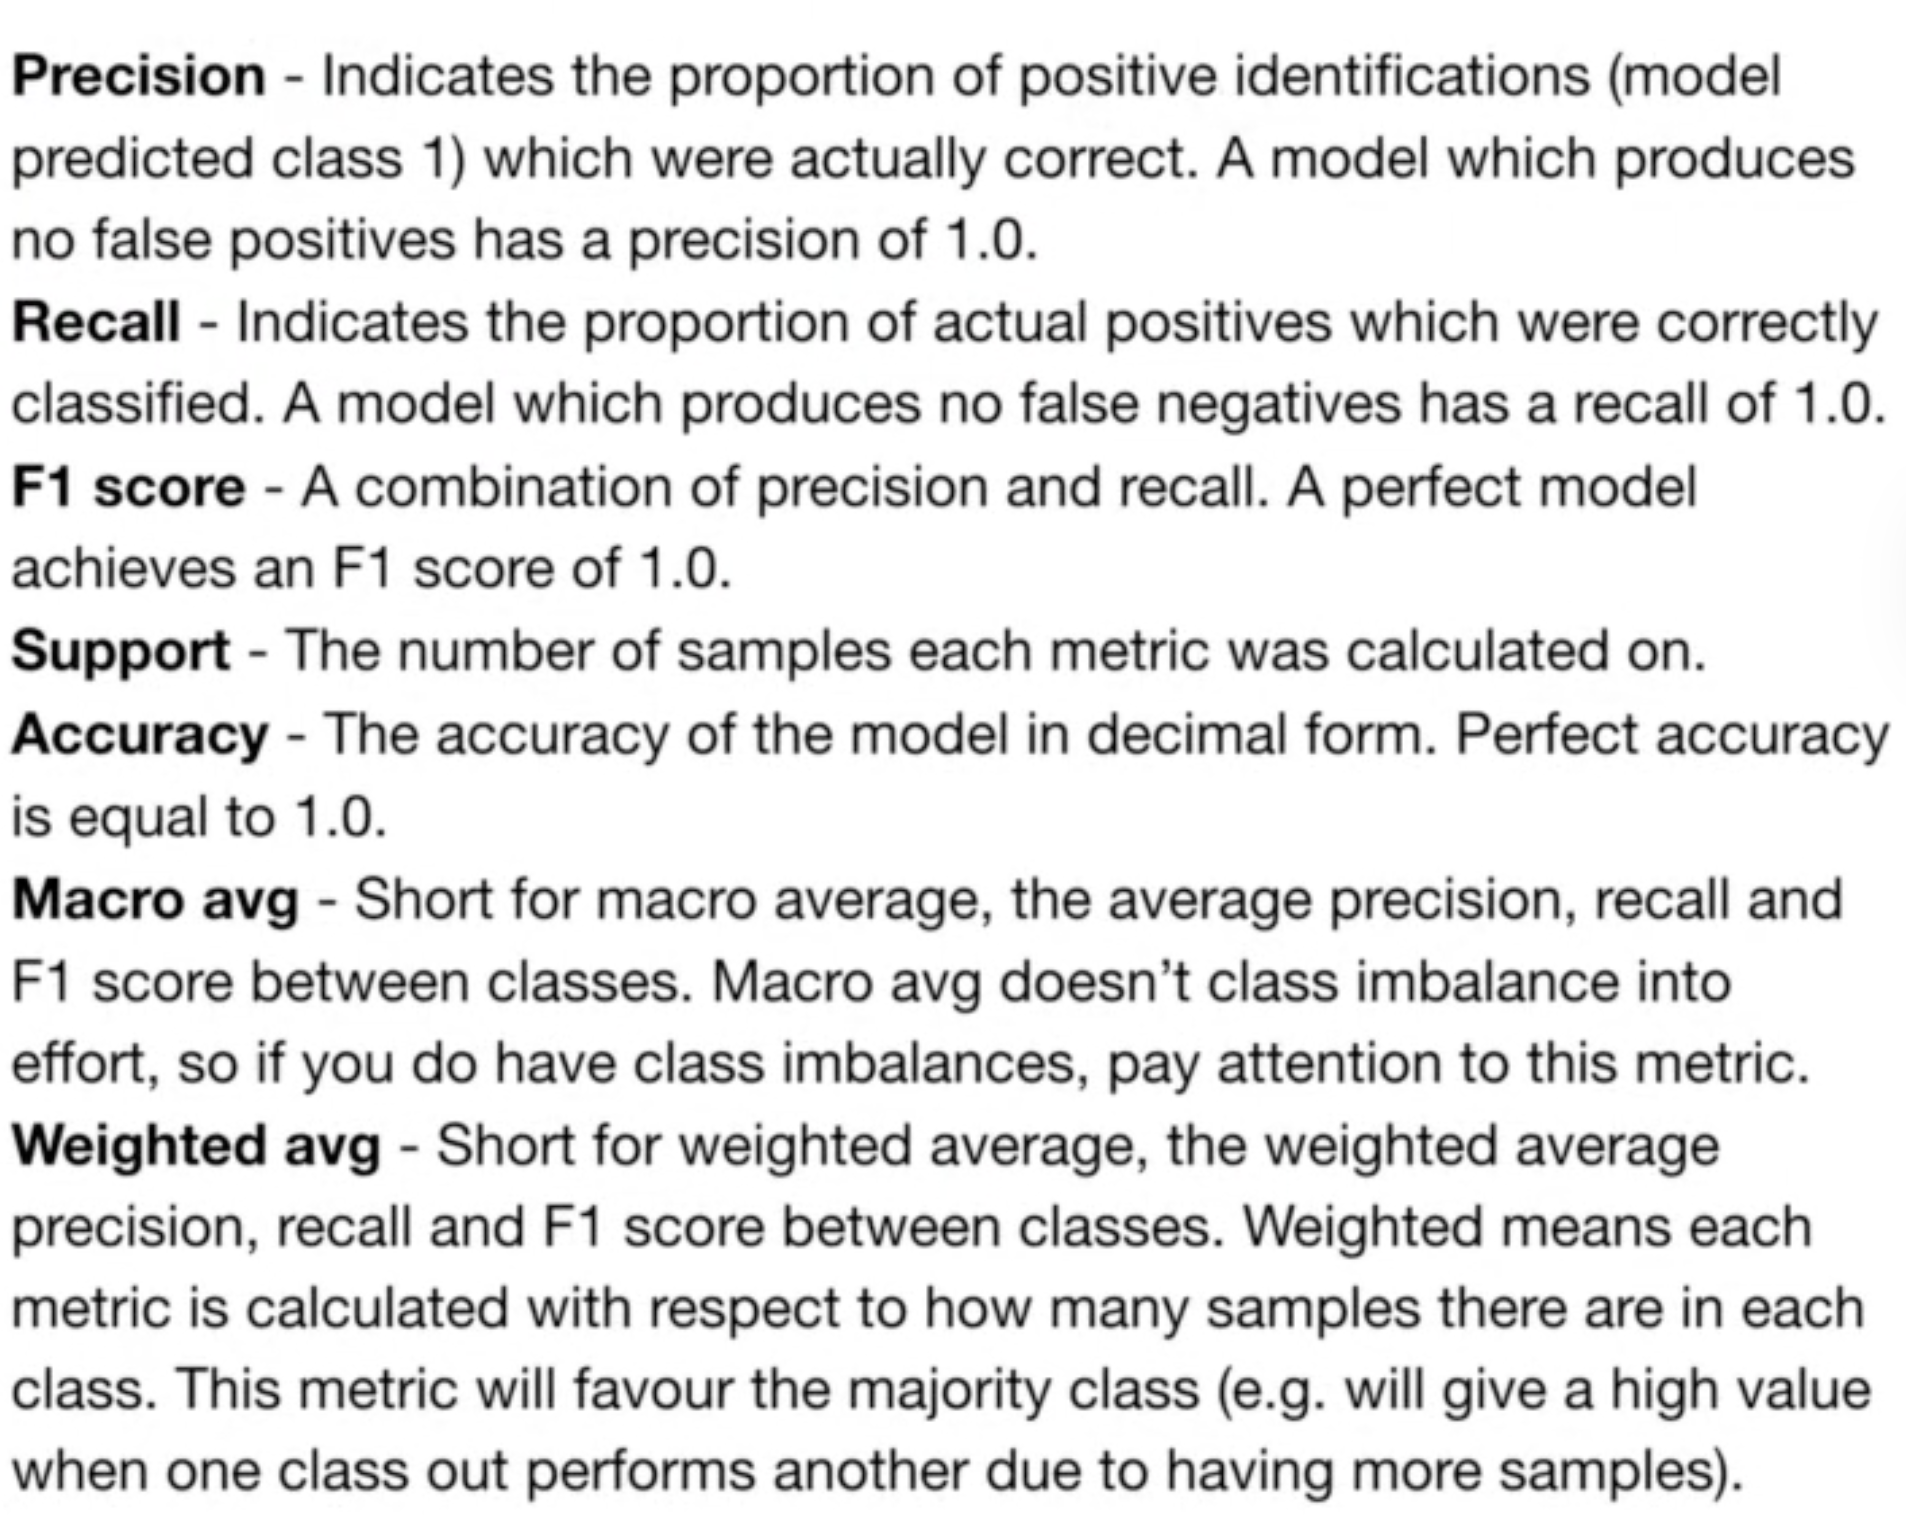

In [ ]:
eval_reports = {}
actual_label = test_and_models_df['Actual Label'].values
for ml_model in ml_models:
    ml_model_name = ml_model.get_model_name()
    print(f"Actual Label:\t\t{actual_label}")
    ml_model_predictions = test_and_models_df[ml_model_name].values
    print(f"{ml_model_name}:\t\t{ml_model_predictions}")
    print()
    eval_report = get_metrics.eval_classification_report(y_test_df, ml_model_predictions)
    eval_reports[ml_model_name] = eval_report

In [ ]:
eval_reports

In [ ]:
eval_reports_df = pd.DataFrame(eval_reports)
eval_reports_df.to_latex()